<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Contoh_transfer_learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Instalasi dan Import Library

In [5]:
# Jika belum, install dulu library yang dibutuhkan
#!pip install tensorflow matplotlib

# Import library
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

# Cell 2: Download dan Ekstrak Dataset

In [6]:
# Di sini digunakan dataset publik 'Flower Photos' dari TensorFlow
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)



228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
import os

print("Data dir:", data_dir)
print("Daftar isi folder utama:")
print(os.listdir(data_dir))

# Cek jumlah dan nama kelas (subfolder):
for name in os.listdir(data_dir):
    sub_path = os.path.join(data_dir, name)
    if os.path.isdir(sub_path):
        print(" -", name)

Data dir: /root/.keras/datasets/flower_photos
Daftar isi folder utama:
['flower_photos']
 - flower_photos


In [15]:
import pathlib

# Data_dir awal menunjuk ke dalam flower_photos satu kali lagi
data_dir = pathlib.Path("/root/.keras/datasets/flower_photos/flower_photos")
print("Isi:", list(data_dir.iterdir()))


Isi: [PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/daisy'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/tulips'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/LICENSE.txt'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses')]


# Cell 3: Persiapan Dataset

In [16]:
# Split data menjadi training dan validation
batch_size = 32
img_height = 160
img_width = 160

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Simpan class names dan num_classes
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Jumlah kelas:", num_classes)

# Normalisasi untuk mempercepat konvergensi
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Jumlah kelas: 5


# Cell 4: Definisikan Model CNN Biasa

In [17]:
# Model CNN sederhana dengan Input layer
model_cnn = models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # GUNAKAN num_classes dari cell 3
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Cell 5: Training dan Evaluasi Model CNN

In [18]:
history_cnn = model_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3061 - loss: 2.1491 - val_accuracy: 0.5545 - val_loss: 1.0948
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6101 - loss: 0.9802 - val_accuracy: 0.6049 - val_loss: 1.0459
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7301 - loss: 0.7456 - val_accuracy: 0.6131 - val_loss: 1.0208
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8587 - loss: 0.4019 - val_accuracy: 0.6185 - val_loss: 1.1849
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9345 - loss: 0.1900 - val_accuracy: 0.6199 - val_loss: 1.4741
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9826 - loss: 0.0741 - val_accuracy: 0.5763 - val_loss: 1.7916
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9915 - loss: 0.0462 - val_accuracy: 0.5790 - val_loss: 2.0422
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9925 - loss: 0.0354 - val_accuracy: 0.5668 - 

# Cell 6: Arsitektur Transfer Learning (MobileNetV2)

In [20]:
# Load pre-trained MobileNetV2, exclude top classifier
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze pretrained layers

model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # num_classes dari cell 3
])


model_tl.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Cell 7: Training dan Evaluasi Model Transfer Learning

In [21]:
history_tl = model_tl.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 338ms/step - accuracy: 0.6989 - loss: 0.8346 - val_accuracy: 0.8392 - val_loss: 0.4203
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9056 - loss: 0.2576 - val_accuracy: 0.8801 - val_loss: 0.3179
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9533 - loss: 0.1433 - val_accuracy: 0.8569 - val_loss: 0.3716
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9764 - loss: 0.0988 - val_accuracy: 0.8883 - val_loss: 0.3380
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9951 - loss: 0.0461 - val_accuracy: 0.8856 - val_loss: 0.3599
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9987 - loss: 0.0269 - val_accuracy: 0.8869 - val_loss: 0.3535
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.8896 - val_loss: 0.3506
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.8842 

# Cell 8: Visualisasi Loss dan Akurasi

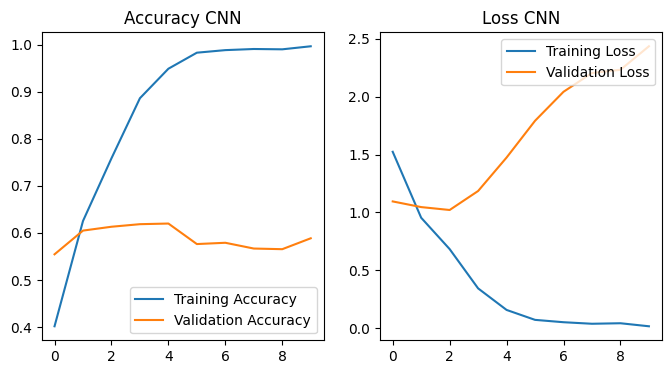

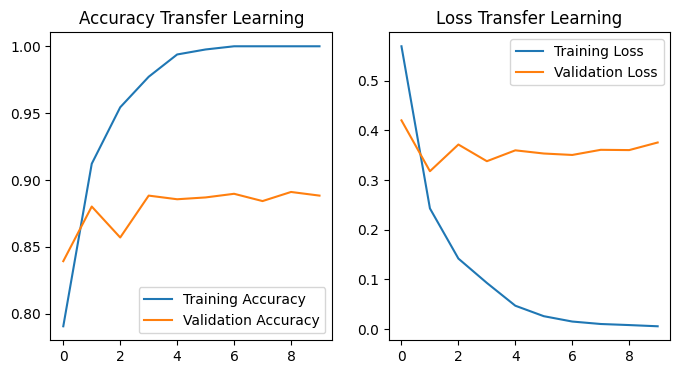

In [22]:
def plot_metrics(history, title_suffix=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy ' + title_suffix)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss ' + title_suffix)
    plt.show()

plot_metrics(history_cnn, title_suffix='CNN')
plot_metrics(history_tl, title_suffix='Transfer Learning')

# Cell 9: Evaluasi Model dan Saran Perbaikan

In [23]:
# Evaluasi di data validasi
val_loss_cnn, val_acc_cnn = model_cnn.evaluate(val_ds)
val_loss_tl, val_acc_tl = model_tl.evaluate(val_ds)

print(f"Model CNN - Validation accuracy: {val_acc_cnn:.2f}, loss: {val_loss_cnn:.2f}")
print(f"Transfer Learning - Validation accuracy: {val_acc_tl:.2f}, loss: {val_loss_tl:.2f}")

# Saran perbaikan:
print("""
Saran perbaikan kinerja model:
- Lanjutkan training transfer learning dengan unfreeze beberapa layer (fine-tuning)
- Coba augmentasi data (rotasi, flip, zoom, dsb.)
- Eksplorasi learning rate dan batch size
- Tambahkan regularisasi seperti dropout
- Gunakan model arsitektur lain yang lebih kompleks untuk dataset yang menantang
""")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5785 - loss: 2.4127
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8827 - loss: 0.3840
Model CNN - Validation accuracy: 0.59, loss: 2.44
Transfer Learning - Validation accuracy: 0.89, loss: 0.38

Saran perbaikan kinerja model:
- Lanjutkan training transfer learning dengan unfreeze beberapa layer (fine-tuning)
- Coba augmentasi data (rotasi, flip, zoom, dsb.)
- Eksplorasi learning rate dan batch size
- Tambahkan regularisasi seperti dropout
- Gunakan model arsitektur lain yang lebih kompleks untuk dataset yang menantang

